In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, fbeta_score, make_scorer

sns.set_theme(style='whitegrid', context='paper')

data = pd.read_csv('data/creditcard/creditcard.csv').drop_duplicates()

In [2]:
X = data.drop(['Class', 'Time'], axis=1)
y = data['Class']

In [3]:
X_train, X_test, y_train, y_true = train_test_split(
    X, y,
    test_size=.8,
    stratify=y,
    random_state=404
)

In [4]:
# For reduced data size:

selected_columns = [
    'V17',
    'V14',
    'V12',
    'V10',
    'V16',
    'V3',
    'V7',
    'V11',
    'V4',
    'V18',
    'V1',
    'V9',
    'V5',
    'V2',
]
X_train_reduced, X_test_reduced, y_train, y_true = train_test_split(
    X[selected_columns], y,
    test_size=.8,
    stratify=y,
    random_state=404
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

In [6]:
# For Finding The Best Result
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

BEST_MODEL = None
BEST_SCORE = None

--------------------------------------------------------------------------------

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=404
).fit(X_train_scaled, y_train)

In [9]:
rf_pred = rf_model.predict(X_test_scaled)

In [10]:
print(f'{(rf_accuracy := accuracy_score(y_true, rf_pred)) = }')
print(f'{(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta)) = }\n')
print(classification_report(y_true, rf_pred))

(rf_accuracy := accuracy_score(y_true, rf_pred)) = 0.9994492931126394
(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta)) = np.float64(0.7603945331969256)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.89      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.95      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



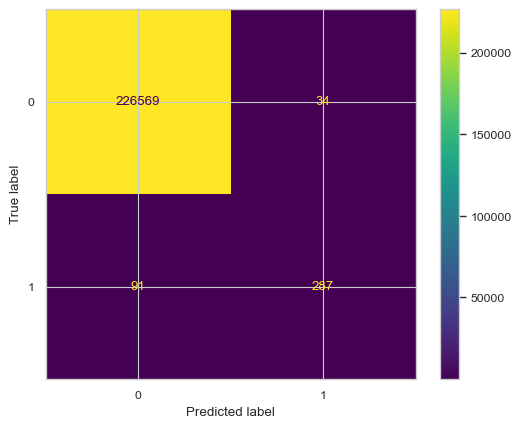

In [11]:
ConfusionMatrixDisplay.from_predictions(y_true, rf_pred)

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [12]:
rf_model_reduced = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=404
).fit(X_train_reduced_scaled, y_train)

rf_reduced_pred = rf_model_reduced.predict(X_test_reduced_scaled)

print(f'{(rf_reduced_accuracy := accuracy_score(y_true, rf_reduced_pred)) = }')
print(f'{(rf_reduced_fbeta := fbeta_score(y_true, rf_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, rf_reduced_pred))

(rf_reduced_accuracy := accuracy_score(y_true, rf_reduced_pred)) = 0.999427264837145
(rf_reduced_fbeta := fbeta_score(y_true, rf_reduced_pred, beta=beta)) = np.float64(0.7655127196433255)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.88      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.94      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



In [13]:
print(f'Impact on the fbeta score: {rf_reduced_fbeta - rf_fbeta = :.6f}')
print('Improvement!') if rf_reduced_fbeta > rf_fbeta else print('Worsened!')

Impact on the fbeta score: rf_reduced_fbeta - rf_fbeta = 0.005118
Improvement!


## Hyperparameter Tuning

Official documentation for the `RandomForestClassifier`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

In [14]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

In [15]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 40, 60, None],         # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)  # for performance reasons, operate on selected columns exclusively

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.789 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.634 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.791 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.581 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.738 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.790 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.634 total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.7

In [16]:
print('-- Training Results --')
print(f'{rf_grid_search.best_params_ = }')
print(f'{rf_grid_search.best_score_ = }\n')

print('-- Testing Results --')
best_rf_reduced_pred = rf_grid_search.predict(X_test_reduced_scaled)

print(f'{(best_rf_reduced_accuracy := accuracy_score(y_true, best_rf_reduced_pred)) = }')
print(f'{(best_rf_reduced_fbeta := fbeta_score(y_true, best_rf_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, best_rf_reduced_pred))

-- Training Results --
rf_grid_search.best_params_ = {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 404}
rf_grid_search.best_score_ = np.float64(0.7379866516950677)

-- Testing Results --
(best_rf_reduced_accuracy := accuracy_score(y_true, best_rf_reduced_pred)) = 0.9994404818024416
(best_rf_reduced_fbeta := fbeta_score(y_true, best_rf_reduced_pred, beta=beta)) = np.float64(0.7707901707272298)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.88      0.77      0.82       378

    accuracy                           1.00    226981
   macro avg       0.94      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



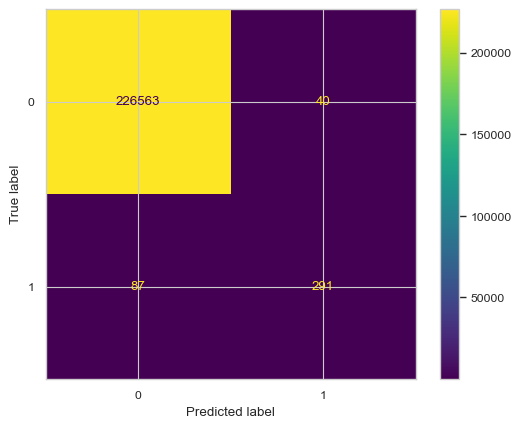

In [17]:
ConfusionMatrixDisplay.from_predictions(y_true, best_rf_reduced_pred)

In [18]:
print('-- HPT Evaluation --')
print(f'{best_rf_reduced_fbeta - rf_reduced_fbeta = :.6f}', end='')
print(' --> Improvement!') if best_rf_reduced_fbeta > rf_reduced_fbeta else print(' --> Worsened!')
print(f'{best_rf_reduced_accuracy - rf_reduced_accuracy = :.6f}', end='')
print(' --> Improvement!') if best_rf_reduced_accuracy > rf_reduced_accuracy else print(' --> Worsened!')

-- HPT Evaluation --
best_rf_reduced_fbeta - rf_reduced_fbeta = 0.005277 --> Improvement!
best_rf_reduced_accuracy - rf_reduced_accuracy = 0.000013 --> Improvement!


In [19]:
BEST_MODEL = f'Random Forest Classifier with Parameters\n{rf_grid_search.best_params_}'
BEST_SCORE = best_rf_reduced_fbeta

print(f'{BEST_MODEL = }\n{BEST_SCORE = :.6f}')

BEST_MODEL = "Random Forest Classifier with Parameters\n{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 150, 'n_jobs': -1, 'random_state': 404}"
BEST_SCORE = 0.770790


--------------------------------------------------------------------------------

# KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=100).fit(X_train_scaled, y_train)

In [21]:
knn_pred = knn_model.predict(X_test_scaled)

In [22]:
print(f'{(knn_accuracy := accuracy_score(y_true, knn_pred)) = }')
print(f'{(knn_fbeta := fbeta_score(y_true, knn_pred, beta=beta)) = }')
print(classification_report(y_true, knn_pred))

(knn_accuracy := accuracy_score(y_true, knn_pred)) = 0.9990219445680475
(knn_fbeta := fbeta_score(y_true, knn_pred, beta=beta)) = np.float64(0.5020514439008995)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.85      0.50      0.63       378

    accuracy                           1.00    226981
   macro avg       0.93      0.75      0.81    226981
weighted avg       1.00      1.00      1.00    226981



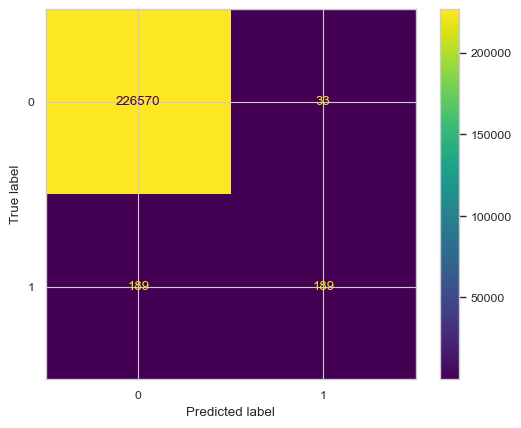

In [23]:
ConfusionMatrixDisplay.from_predictions(y_true, knn_pred)

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [24]:
knn_model_reduced = KNeighborsClassifier(
    n_neighbors=100
).fit(X_train_reduced_scaled, y_train)

knn_reduced_pred = knn_model_reduced.predict(X_test_reduced_scaled)

print(f'{(knn_reduced_accuracy := accuracy_score(y_true, knn_reduced_pred)) = }')
print(f'{(knn_reduced_fbeta := fbeta_score(y_true, knn_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, knn_reduced_pred))

(knn_reduced_accuracy := accuracy_score(y_true, knn_reduced_pred)) = 0.9990880293945308
(knn_reduced_fbeta := fbeta_score(y_true, knn_reduced_pred, beta=beta)) = np.float64(0.5469362004153413)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.85      0.54      0.67       378

    accuracy                           1.00    226981
   macro avg       0.93      0.77      0.83    226981
weighted avg       1.00      1.00      1.00    226981



In [25]:
print(f'Impact on the fbeta score: {knn_reduced_fbeta - knn_fbeta = :.6f}')
print('Improvement!') if knn_reduced_fbeta > knn_fbeta else print('Worsened!')

Impact on the fbeta score: knn_reduced_fbeta - knn_fbeta = 0.044885
Improvement!


## Hyperparameter Tuning

In [26]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

In [27]:
knn_param_grid = {
    'n_neighbors': [5, 10, 20, 50, 100, 150],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
}
knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.946 total time=   0.5s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.738 total time=   0.5s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.791 total time=   0.5s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.528 total time=   0.5s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.789 total time=   0.5s
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.946 total time=   0.4s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.738 total time=   0.4s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.791 total time=   0.4s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.528 total time=   0.4s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.789 total time=   0.4s
[CV 1/5] END n_jobs=-1, n_neighbors=10, weights=unifor

In [28]:
print('-- Training Results --')
print(f'{knn_grid_search.best_params_ = }')
print(f'{knn_grid_search.best_score_ = }\n')

print('-- Testing Results --')
best_knn_reduced_pred = knn_grid_search.predict(X_test_reduced_scaled)

print(f'{(best_knn_reduced_accuracy := accuracy_score(y_true, best_knn_reduced_pred)) = }')
print(f'{(best_knn_reduced_fbeta := fbeta_score(y_true, best_knn_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, best_knn_reduced_pred))

-- Training Results --
knn_grid_search.best_params_ = {'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}
knn_grid_search.best_score_ = np.float64(0.7690816546462947)

-- Testing Results --
(best_knn_reduced_accuracy := accuracy_score(y_true, best_knn_reduced_pred)) = 0.9993611800106617
(best_knn_reduced_fbeta := fbeta_score(y_true, best_knn_reduced_pred, beta=beta)) = np.float64(0.7886696538532086)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.79      0.80       378

    accuracy                           1.00    226981
   macro avg       0.91      0.89      0.90    226981
weighted avg       1.00      1.00      1.00    226981



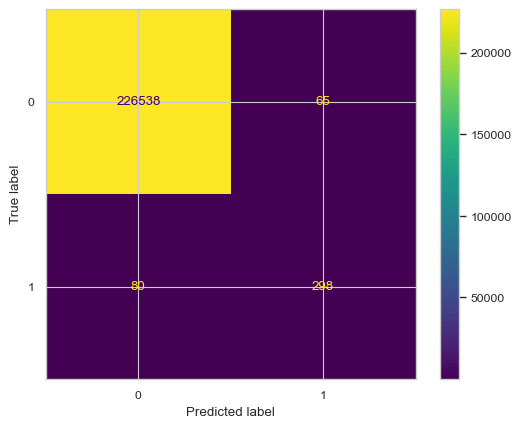

In [29]:
ConfusionMatrixDisplay.from_predictions(y_true, best_knn_reduced_pred)

In [30]:
print('-- HPT Evaluation --')
print(f'{best_knn_reduced_fbeta - knn_reduced_fbeta = :.6f}', end='')
print(' --> Improvement!') if best_knn_reduced_fbeta > knn_reduced_fbeta else print(' --> Worsened!')
print(f'{best_knn_reduced_accuracy - knn_reduced_accuracy = :.6f}', end='')
print(' --> Improvement!') if best_knn_reduced_accuracy > knn_reduced_accuracy else print(' --> Worsened!')

-- HPT Evaluation --
best_knn_reduced_fbeta - knn_reduced_fbeta = 0.241733 --> Improvement!
best_knn_reduced_accuracy - knn_reduced_accuracy = 0.000273 --> Improvement!


In [31]:
if best_knn_reduced_fbeta > BEST_SCORE:
    BEST_MODEL = f'KNN Classifier with Parameters\n{knn_grid_search.best_params_}'
    BEST_SCORE = best_knn_reduced_fbeta

print(f'{BEST_MODEL = }\n{BEST_SCORE = :.6f}')

BEST_MODEL = "KNN Classifier with Parameters\n{'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}"
BEST_SCORE = 0.788670


--------------------------------------------------------------------------------

# Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

gnb_model = GaussianNB().fit(X_train_scaled, y_train)

In [33]:
gnb_pred = gnb_model.predict(X_test_scaled)

In [34]:
print(f'{(gnb_accuracy := accuracy_score(y_true, gnb_pred)) = }')
print(f'{(gnb_fbeta := fbeta_score(y_true, gnb_pred, beta=beta)) = }')
print(classification_report(y_true, gnb_pred))

(gnb_accuracy := accuracy_score(y_true, gnb_pred)) = 0.9768482824553597
(gnb_fbeta := fbeta_score(y_true, gnb_pred, beta=beta)) = np.float64(0.7461273864764412)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    226603
           1       0.06      0.85      0.11       378

    accuracy                           0.98    226981
   macro avg       0.53      0.91      0.55    226981
weighted avg       1.00      0.98      0.99    226981



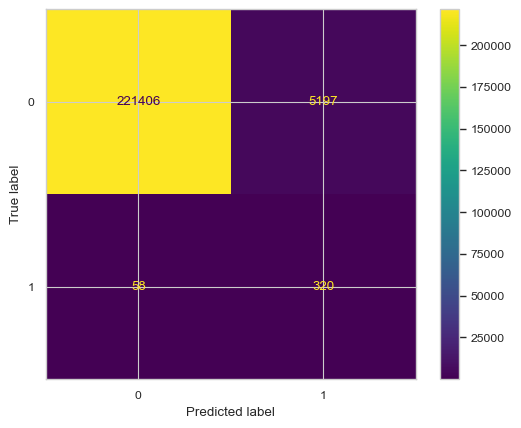

In [35]:
ConfusionMatrixDisplay.from_predictions(y_true, gnb_pred)

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [36]:
gnb_model_reduced = GaussianNB().fit(X_train_reduced_scaled, y_train)

gnb_reduced_pred = gnb_model_reduced.predict(X_test_reduced_scaled)

print(f'{(gnb_reduced_accuracy := accuracy_score(y_true, gnb_reduced_pred)) = }')
print(f'{(gnb_reduced_fbeta := fbeta_score(y_true, gnb_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, gnb_reduced_pred))

(gnb_reduced_accuracy := accuracy_score(y_true, gnb_reduced_pred)) = 0.9859591771998537
(gnb_reduced_fbeta := fbeta_score(y_true, gnb_reduced_pred, beta=beta)) = np.float64(0.7835341462823341)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226603
           1       0.09      0.85      0.17       378

    accuracy                           0.99    226981
   macro avg       0.55      0.92      0.58    226981
weighted avg       1.00      0.99      0.99    226981



In [37]:
print(f'Impact on the fbeta score: {gnb_reduced_fbeta - gnb_fbeta = :.6f}')
print('Improvement!') if gnb_reduced_fbeta > gnb_fbeta else print('Worsened!')

Impact on the fbeta score: gnb_reduced_fbeta - gnb_fbeta = 0.037407
Improvement!


## Hyperparameter Tuning

In [38]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

In [39]:
rel_positive = len(y[y==1]) / len(y)
gnb_param_grid = {
    'priors': [None, [1 - rel_positive, rel_positive]]
}
gnb_grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .......................priors=None;, score=0.868 total time=   0.0s
[CV 2/5] END .......................priors=None;, score=0.828 total time=   0.0s
[CV 3/5] END .......................priors=None;, score=0.731 total time=   0.0s
[CV 4/5] END .......................priors=None;, score=0.738 total time=   0.0s
[CV 5/5] END .......................priors=None;, score=0.784 total time=   0.0s
[CV 1/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.868 total time=   0.0s
[CV 2/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.828 total time=   0.0s
[CV 3/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.731 total time=   0.0s
[CV 4/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.738 total time=   0.0s
[CV 5/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.784 total time=   0.0s


In [40]:
print('-- Training Results --')
print(f'{gnb_grid_search.best_params_ = }')
print(f'{gnb_grid_search.best_score_ = }\n')

print('-- Testing Results --')
best_gnb_reduced_pred = gnb_grid_search.predict(X_test_reduced_scaled)

print(f'{(best_gnb_reduced_accuracy := accuracy_score(y_true, best_gnb_reduced_pred)) = }')
print(f'{(best_gnb_reduced_fbeta := fbeta_score(y_true, best_gnb_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, best_gnb_reduced_pred))

-- Training Results --
gnb_grid_search.best_params_ = {'priors': None}
gnb_grid_search.best_score_ = np.float64(0.7897917078482706)

-- Testing Results --
(best_gnb_reduced_accuracy := accuracy_score(y_true, best_gnb_reduced_pred)) = 0.9859591771998537
(best_gnb_reduced_fbeta := fbeta_score(y_true, best_gnb_reduced_pred, beta=beta)) = np.float64(0.7835341462823341)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226603
           1       0.09      0.85      0.17       378

    accuracy                           0.99    226981
   macro avg       0.55      0.92      0.58    226981
weighted avg       1.00      0.99      0.99    226981



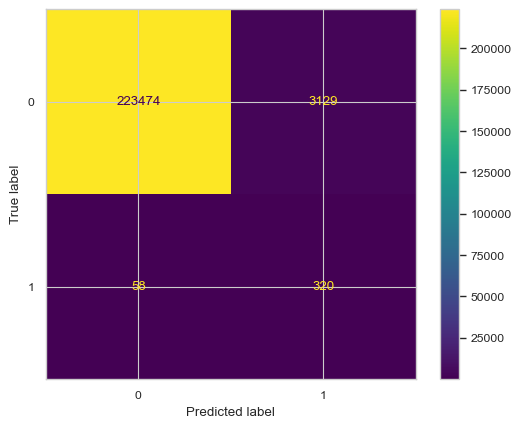

In [41]:
ConfusionMatrixDisplay.from_predictions(y_true, best_gnb_reduced_pred)

In [42]:
print('-- HPT Evaluation --')
print(f'{best_gnb_reduced_fbeta - gnb_reduced_fbeta = :.6f}', end='')
print(' --> Improvement!') if best_gnb_reduced_fbeta > gnb_reduced_fbeta else print(' --> Worsened!')
print(f'{best_gnb_reduced_accuracy - gnb_reduced_accuracy = :.6f}', end='')
print(' --> Improvement!') if best_gnb_reduced_accuracy > gnb_reduced_accuracy else print(' --> Worsened!')

-- HPT Evaluation --
best_gnb_reduced_fbeta - gnb_reduced_fbeta = 0.000000 --> Worsened!
best_gnb_reduced_accuracy - gnb_reduced_accuracy = 0.000000 --> Worsened!


In [43]:
if best_gnb_reduced_fbeta > BEST_SCORE:
    BEST_MODEL = f'(Gaussian) Naive Bayes Classifier with Parameters\n{gnb_grid_search.best_params_}'
    BEST_SCORE = best_gnb_reduced_fbeta

print(f'{BEST_MODEL = }\n{BEST_SCORE = :.6f}')

BEST_MODEL = "KNN Classifier with Parameters\n{'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}"
BEST_SCORE = 0.788670


--------------------------------------------------------------------------------

# Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

In [45]:
lr_pred = lr_model.predict(X_test_scaled)

In [46]:
print(f'{(lr_accuracy := accuracy_score(y_true, lr_pred)) = }')
print(f'{(lr_fbeta := fbeta_score(y_true, lr_pred, beta=beta)) = }')
print(classification_report(y_true, lr_pred))

(lr_accuracy := accuracy_score(y_true, lr_pred)) = 0.999193765116904
(lr_fbeta := fbeta_score(y_true, lr_pred, beta=beta)) = np.float64(0.654794089083703)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.83      0.65      0.73       378

    accuracy                           1.00    226981
   macro avg       0.91      0.83      0.86    226981
weighted avg       1.00      1.00      1.00    226981



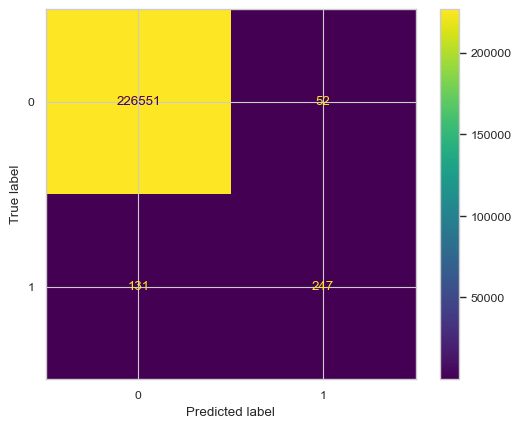

In [47]:
ConfusionMatrixDisplay.from_predictions(y_true, lr_pred)

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [48]:
lr_model_reduced = LogisticRegression(
    max_iter=1000
).fit(X_train_reduced_scaled, y_train)

lr_reduced_pred = lr_model_reduced.predict(X_test_reduced_scaled)

print(f'{(lr_reduced_accuracy := accuracy_score(y_true, lr_reduced_pred)) = }')
print(f'{(lr_reduced_fbeta := fbeta_score(y_true, lr_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, lr_reduced_pred))

(lr_reduced_accuracy := accuracy_score(y_true, lr_reduced_pred)) = 0.9992554442882885
(lr_reduced_fbeta := fbeta_score(y_true, lr_reduced_pred, beta=beta)) = np.float64(0.6602693691091917)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.86      0.66      0.75       378

    accuracy                           1.00    226981
   macro avg       0.93      0.83      0.87    226981
weighted avg       1.00      1.00      1.00    226981



In [49]:
print(f'Impact on the fbeta score: {lr_reduced_fbeta - lr_fbeta = :.6f}')
print('Improvement!') if lr_reduced_fbeta > lr_fbeta else print('Worsened!')

Impact on the fbeta score: lr_reduced_fbeta - lr_fbeta = 0.005475
Improvement!


## Hyperparameter Tuning

In [50]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
lr_param_grid = {
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5, 1.e-6],
    'C': [0.4 + 0.2*n for n in range(6)],
    'fit_intercept': [True, False],
    'max_iter': [1500],
    'n_jobs': [-1],
    'random_state': [404],
}
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=lr_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.842 total time=   2.6s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.529 total time=   0.4s
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.739 total time=   0.4s
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.476 total time=   1.1s
[CV 5/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.633 total time=   1.1s
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.842 total time=   1.1s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=1500, n_jobs=-1, penalty=l2, random_state=404, tol

In [53]:
print('-- Training Results --')
print(f'{lr_grid_search.best_params_ = }')
print(f'{lr_grid_search.best_score_ = }\n')

print('-- Testing Results --')
best_lr_reduced_pred = lr_grid_search.predict(X_test_reduced_scaled)

print(f'{(best_lr_reduced_accuracy := accuracy_score(y_true, best_lr_reduced_pred)) = }')
print(f'{(best_lr_reduced_fbeta := fbeta_score(y_true, best_lr_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, best_lr_reduced_pred))

-- Training Results --
lr_grid_search.best_params_ = {'C': 0.4, 'fit_intercept': True, 'max_iter': 1500, 'n_jobs': -1, 'penalty': None, 'random_state': 404, 'tol': 1e-06}
lr_grid_search.best_score_ = np.float64(0.675225123550993)

-- Testing Results --
(best_lr_reduced_accuracy := accuracy_score(y_true, best_lr_reduced_pred)) = 0.9992510386331895
(best_lr_reduced_fbeta := fbeta_score(y_true, best_lr_reduced_pred, beta=beta)) = np.float64(0.6576349506406217)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.86      0.66      0.74       378

    accuracy                           1.00    226981
   macro avg       0.93      0.83      0.87    226981
weighted avg       1.00      1.00      1.00    226981



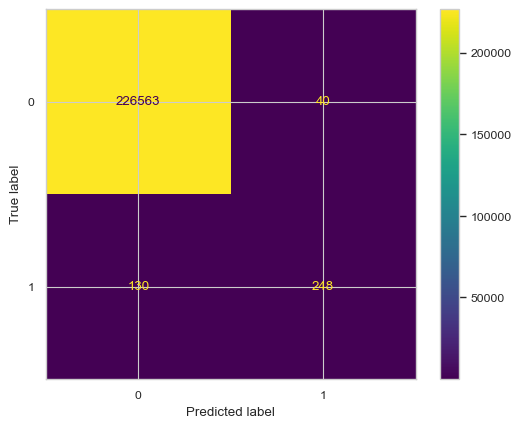

In [54]:
ConfusionMatrixDisplay.from_predictions(y_true, best_lr_reduced_pred)

In [55]:
print('-- HPT Evaluation --')
print(f'{best_lr_reduced_fbeta - lr_reduced_fbeta = :.6f}', end='')
print(' --> Improvement!') if best_lr_reduced_fbeta > lr_reduced_fbeta else print(' --> Worsened!')
print(f'{best_lr_reduced_accuracy - lr_reduced_accuracy = :.6f}', end='')
print(' --> Improvement!') if best_lr_reduced_accuracy > lr_reduced_accuracy else print(' --> Worsened!')

-- HPT Evaluation --
best_lr_reduced_fbeta - lr_reduced_fbeta = -0.002634 --> Worsened!
best_lr_reduced_accuracy - lr_reduced_accuracy = -0.000004 --> Worsened!


In [56]:
if best_lr_reduced_fbeta > BEST_SCORE:
    BEST_MODEL = f'Logistic Regression with Parameters\n{lr_grid_search.best_params_}'
    BEST_SCORE = best_lr_reduced_fbeta

print(f'{BEST_MODEL = }\n{BEST_SCORE = :.6f}')

BEST_MODEL = "KNN Classifier with Parameters\n{'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}"
BEST_SCORE = 0.788670


--------------------------------------------------------------------------------

# Support Vector Machine

In [57]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', C=1.).fit(X_train_scaled, y_train)

In [58]:
svc_pred = svc_model.predict(X_test_scaled)

In [59]:
print(f'{(svc_accuracy := accuracy_score(y_true, svc_pred)) = }')
print(f'{(svc_fbeta := fbeta_score(y_true, svc_pred, beta=beta)) = }')
print(classification_report(y_true, svc_pred))

(svc_accuracy := accuracy_score(y_true, svc_pred)) = 0.9993171234596728
(svc_fbeta := fbeta_score(y_true, svc_pred, beta=beta)) = np.float64(0.7467554600036705)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.83      0.75      0.78       378

    accuracy                           1.00    226981
   macro avg       0.91      0.87      0.89    226981
weighted avg       1.00      1.00      1.00    226981



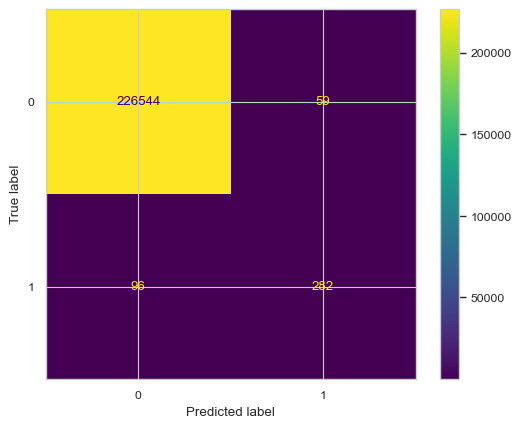

In [60]:
ConfusionMatrixDisplay.from_predictions(y_true, svc_pred)

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [61]:
svc_model_reduced = SVC(
    kernel='linear',
    C=1.
).fit(X_train_reduced_scaled, y_train)

svc_reduced_pred = svc_model_reduced.predict(X_test_reduced_scaled)

print(f'{(svc_reduced_accuracy := accuracy_score(y_true, svc_reduced_pred)) = }')
print(f'{(svc_reduced_fbeta := fbeta_score(y_true, svc_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, svc_reduced_pred))

(svc_reduced_accuracy := accuracy_score(y_true, svc_reduced_pred)) = 0.9993699913208595
(svc_reduced_fbeta := fbeta_score(y_true, svc_reduced_pred, beta=beta)) = np.float64(0.7939211319271584)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.79      0.81       378

    accuracy                           1.00    226981
   macro avg       0.91      0.90      0.90    226981
weighted avg       1.00      1.00      1.00    226981



In [62]:
print(f'Impact on the fbeta score: {svc_reduced_fbeta - svc_fbeta = :.6f}')
print('Improvement!') if svc_reduced_fbeta > svc_fbeta else print('Worsened!')

Impact on the fbeta score: svc_reduced_fbeta - svc_fbeta = 0.047166
Improvement!


## Hyperparameter Tuning

In [63]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta)

In [64]:
svc_param_grid = {
    'C': [0.4 + 0.2*n for n in range(6)],
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, len(selected_columns)],
    'gamma': ['scale', 'auto'],
    'tol': [1.e-3, 1.e-5, 1.e-6],
    'max_iter': [10_000],
    'random_state': [404]
}
svc_grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=svc_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.946 total time=   0.8s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.686 total time=   0.7s
[CV 3/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.791 total time=   0.6s
[CV 4/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.580 total time=   0.5s
[CV 5/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.737 total time=   0.7s
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=0.946 total time=   0.8s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=0.686 total time

In [65]:
print('-- Training Results --')
print(f'{svc_grid_search.best_params_ = }')
print(f'{svc_grid_search.best_score_ = }\n')

print('-- Testing Results --')
best_svc_reduced_pred = svc_grid_search.predict(X_test_reduced_scaled)

print(f'{(best_svc_reduced_accuracy := accuracy_score(y_true, best_svc_reduced_pred)) = }')
print(f'{(best_svc_reduced_fbeta := fbeta_score(y_true, best_svc_reduced_pred, beta=beta)) = }\n')
print(classification_report(y_true, best_svc_reduced_pred))

-- Training Results --
svc_grid_search.best_params_ = {'C': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 10000, 'random_state': 404, 'tol': 0.001}
svc_grid_search.best_score_ = np.float64(0.7690816546462947)

-- Testing Results --
(best_svc_reduced_accuracy := accuracy_score(y_true, best_svc_reduced_pred)) = 0.9993655856657606
(best_svc_reduced_fbeta := fbeta_score(y_true, best_svc_reduced_pred, beta=beta)) = np.float64(0.796504925592119)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.80      0.81       378

    accuracy                           1.00    226981
   macro avg       0.91      0.90      0.90    226981
weighted avg       1.00      1.00      1.00    226981



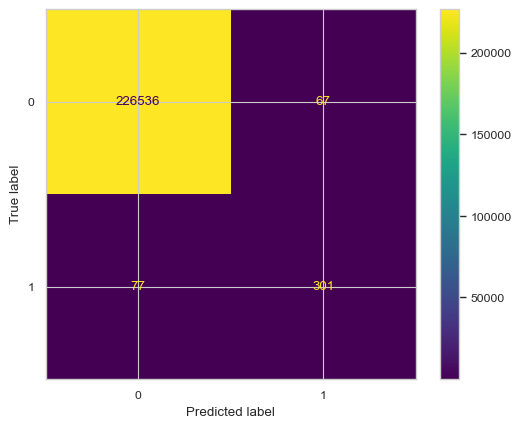

In [66]:
ConfusionMatrixDisplay.from_predictions(y_true, best_svc_reduced_pred)

In [67]:
print('-- HPT Evaluation --')
print(f'{best_svc_reduced_fbeta - svc_reduced_fbeta = :.6f}', end='')
print(' --> Improvement!') if best_svc_reduced_fbeta > svc_reduced_fbeta else print(' --> Worsened!')
print(f'{best_svc_reduced_accuracy - svc_reduced_accuracy = :.6f}', end='')
print(' --> Improvement!') if best_svc_reduced_accuracy > svc_reduced_accuracy else print(' --> Worsened!')

-- HPT Evaluation --
best_svc_reduced_fbeta - svc_reduced_fbeta = 0.002584 --> Improvement!
best_svc_reduced_accuracy - svc_reduced_accuracy = -0.000004 --> Worsened!


In [68]:
if best_svc_reduced_fbeta > BEST_SCORE:
    BEST_MODEL = f'Support Vector Classifier with Parameters\n{svc_grid_search.best_params_}'
    BEST_SCORE = best_svc_reduced_fbeta

print(f'{BEST_MODEL = }\n{BEST_SCORE = :.6f}')

BEST_MODEL = "Support Vector Classifier with Parameters\n{'C': 1.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 10000, 'random_state': 404, 'tol': 0.001}"
BEST_SCORE = 0.796505
